# 3.1 Datenvisualisierung und -vorbereitung

In [2]:

import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import der URL
url = 'https://opendata.dwd.de/climate_environment/CDC/regional_averages_DE/monthly/air_temperature_mean/'
response = requests.get(url)
content = response.content
soup = BeautifulSoup(content, 'html.parser')
links = soup.find_all('a')
txt_links = [link['href'] for link in links if link['href'].endswith('.txt')]
txt_urls = [url + txt_link for txt_link in txt_links]

# Initialisierung der Liste für DataFrames
dataframes = []

# Iteration über alle Text-URLs
for txt_url in txt_urls:
    # Erzeugung eines DataFrame für jede URL
    df = pd.read_csv(txt_url, delimiter=';', header=1)
    df.set_index('Jahr', inplace=True)
    # Entfernung aller anderen Spalten außer Baden-Württemberg
    df = df.loc[:, ['Baden-Wuerttemberg']]
    # Entfernung des Jahres 2023, da es noch nicht abgeschlossen ist
    if df.shape[0] == 143:
        last_row_index = df.index[-1]
        df = df.drop(last_row_index)
    # Hinzufügen des DataFrame zur Liste
    dataframes.append(df)

# Zusammenführen aller DataFrames in ein einziges DataFrame
combined_df = pd.concat(dataframes)

# Ab hier wird die Struktur der DataFrames verändert, sodass es sich um eine Zeitreihe handelt. 
# Zuerst wird eine Liste erstellt, die die Werte in der richtigen Struktur enthält.
monthly_temp_142years = []
for i in range(142):
    for j in range(i, combined_df.shape[0], 142):
        monthly_temp_142years.append(combined_df.iloc[j,0])

# Aktualisierung der neuen Struktur der Werte in den DataFrames
combined_df['Baden-Wuerttemberg'] = monthly_temp_142years

# Aktualisierung der neuen Indexstruktur (Jahre) für die DataFrames
list_year = []
for i in range(1881, 2023):
    for j in range(12):
        list_year.append(str(i))
date_range = pd.date_range(start='1881-01-01', end='2023-01-01', freq='M')
formatted_date_range = date_range.strftime('%Y-%B')
combined_df.index = formatted_date_range

# Ausgabe der ersten Zeilen des kombinierten DataFrame
print(combined_df.head())


               Baden-Wuerttemberg
1881-January                -4.89
1881-February                1.33
1881-March                   4.42
1881-April                   6.63
1881-May                    11.44


Abbildung 3.1

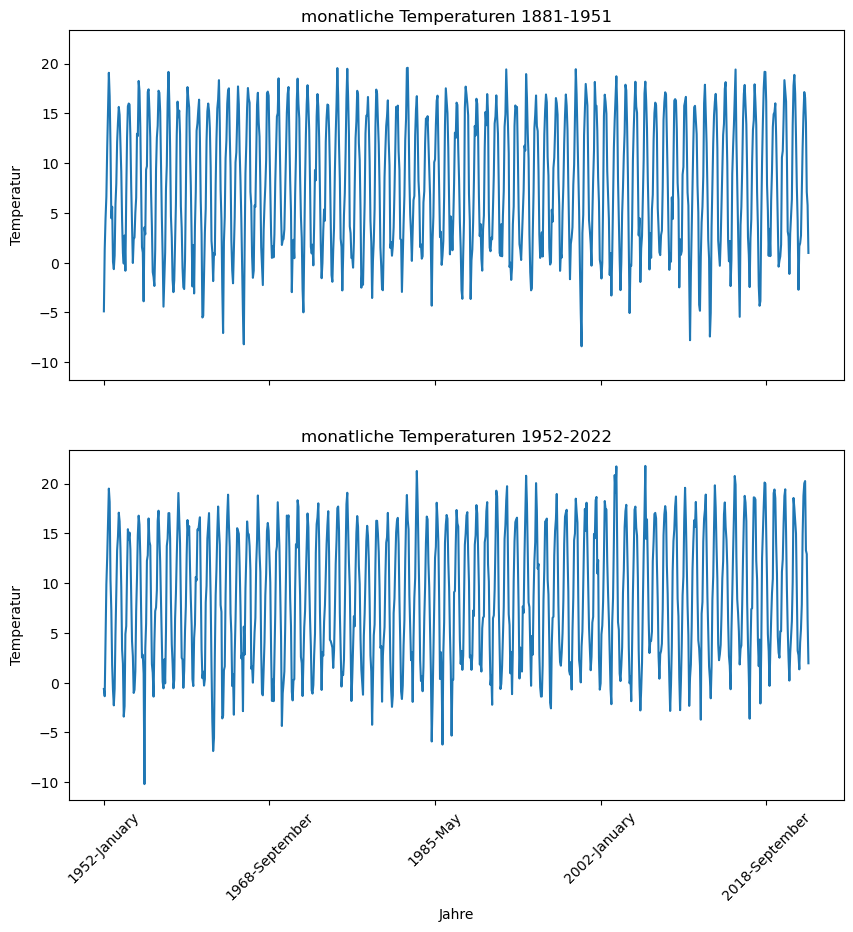

In [25]:
# Erstellung eines Diagramms mit zwei Subplots, die dieselben x- und y-Achsen teilen
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True, sharey=True)

# Darstellung der Daten von 1881 bis 1951 im ersten Subplot
combined_df.loc['1881-January':'1951-December', 'Baden-Wuerttemberg'].plot(ax=ax1)
ax1.set_title('monatliche Temperaturen 1881-1951')
ax1.set_ylabel('Temperatur')

# Darstellung der Daten von 1952 bis 2022 im zweiten Subplot
combined_df.loc['1952-January':'2022-December', 'Baden-Wuerttemberg'].plot(ax=ax2)
ax2.set_title('monatliche Temperaturen 1952-2022')
ax2.set_ylabel('Temperatur')
ax2.set_xlabel('Jahre')

# Einstellen der Drehung der x-Achsen-Beschriftungen auf 45 Grad
plt.xticks(rotation=45)

plt.show()


# 3.2 Datenverschiebung und Logarithmierung

In [4]:
minimaler_wert = combined_df['Baden-Wuerttemberg'].min()
print("Minimaler Wert:", minimaler_wert)

Minimaler Wert: -10.19


Jetzt werden die Werten um 15 addiert und logarithmiert

In [5]:
# Alle Werte im DataFrame um 15 erhöhen und logarithmieren
combined_df['Baden-Wuerttemberg_log'] = np.log(combined_df['Baden-Wuerttemberg'] + 15)


Und plotten wie oben

Abbildung 3.2

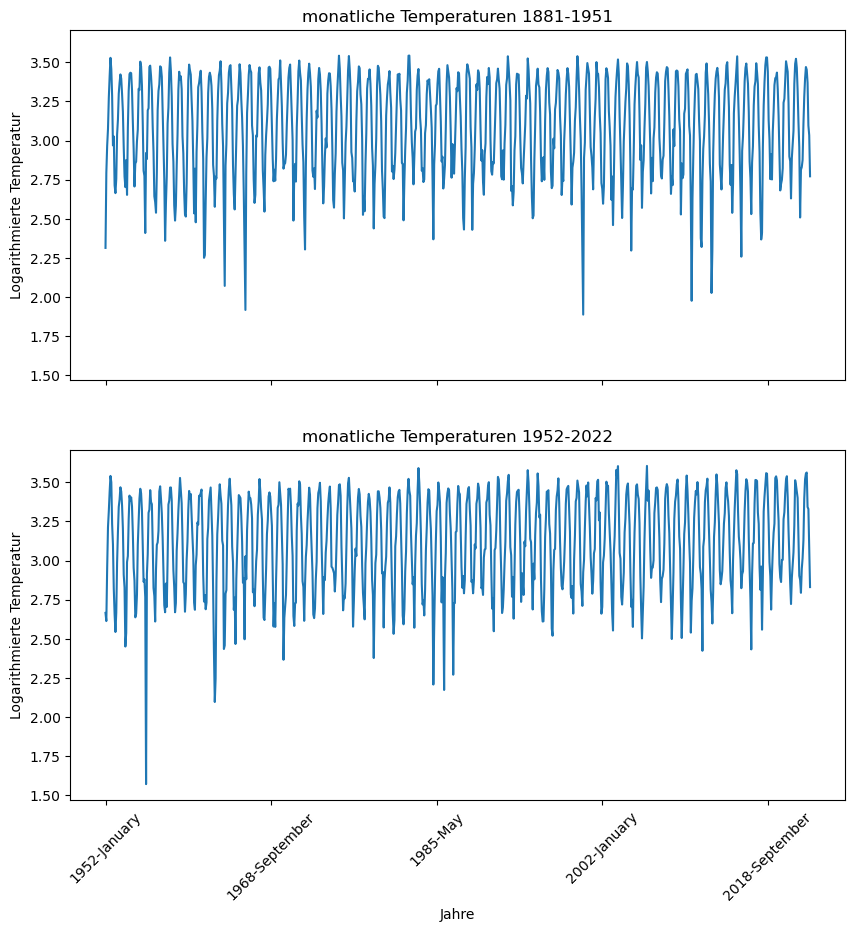

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True, sharey=True)

# Darstellung der Daten von 1881 bis 1951 im ersten Subplot
combined_df.loc['1881-January':'1951-December', 'Baden-Wuerttemberg_log'].plot(ax=ax1)
ax1.set_title('monatliche Temperaturen 1881-1951')
ax1.set_ylabel('Logarithmierte Temperatur')

# Darstellung der Daten von 1952 bis 2022 im zweiten Subplot
combined_df.loc['1952-January':'2022-December', 'Baden-Wuerttemberg_log'].plot(ax=ax2)
ax2.set_title('monatliche Temperaturen 1952-2022')
ax2.set_ylabel('Logarithmierte Temperatur')
ax2.set_xlabel('Jahre')

plt.xticks(rotation=45)

plt.show()


Funktion für adfuller test. Hier wird die logarithmierte und verschobene Zeitreihe getestet.

In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df, column, start, end):
    data = df.loc[start:end, column]
    result = adfuller(data, regression='n')
    print("Test statistic = {:.4f}".format(result[0]))
    print("p-value = {:.4f}".format(result[1]))
    return result


adf_result = adf_test(combined_df, 'Baden-Wuerttemberg_log', '1881-February', '2022-December')


Test statistic = 0.2388
p-value = 0.7579


# 3.3 Trend- und Periodizitätskomponenten entfernen

Durch seasonal_decompose() die Trend- und Saisonalität von der Zeitreihe entfernen und visualisieren.

Abbildung 3.3

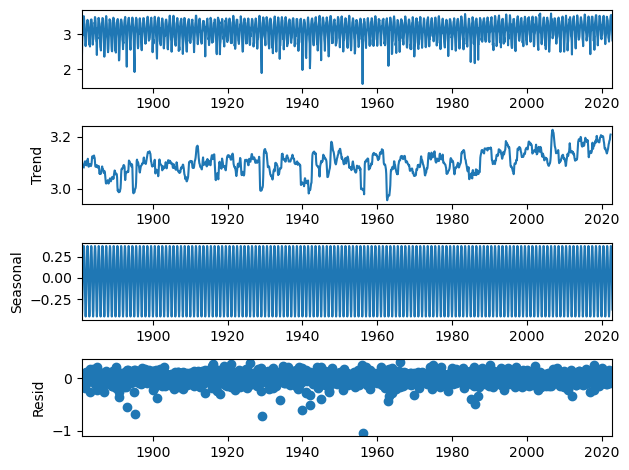

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Index für die Series erstellen
date_rng = pd.date_range(start='1881-01-01', end='2022-12-01', freq='MS')
data = {
    'Month': date_rng.strftime('%Y-%B'),
    'Baden-Wuerttemberg_log': np.random.normal(0, 1, len(date_rng))
}

# Series erstellen
time_series = pd.Series(combined_df['Baden-Wuerttemberg_log'].values, index=date_rng)


# Zerlegung der Zeitreihen
result_1 = seasonal_decompose(time_series, model='additive', period=12)
#result_2 = seasonal_decompose(time_series_2, model='additive', period=12)

# Ergebnisse plotten
result_1.plot()
plt.show()


## 3.3.1 Die Komponenten visualisieren

### 3.3.2 Differenzierungsmethode

Ein Skript, um ACF und PACF für die gegebenen Dataframes in einem bestimmten Bereich zu plotten:

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf_values(df, column, start, end):
    # Extraktion der Daten aus dem DataFrame
    data = df.loc[start:end, column]

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 16))

    # Darstellung des gegebenen Wertebereichs
    axes[0].plot(data)
    axes[0].set_title(f'Temperaturen von {start} bis {end}')
    axes[0].set_xlabel('Jahre')
    axes[0].set_ylabel('Temperatur')
    axes[0].xaxis.set_major_locator(plt.MaxNLocator(5))
    
    # Darstellung der Autokorrelationsfunktion (ACF)
    plot_acf(data, ax=axes[1], title=f'ACF von {start} bis {end}')

    # Darstellung der partiellen Autokorrelationsfunktion (PACF)
    plot_pacf(data, ax=axes[2], title=f'PACF von {start} bis {end}')

    plt.show()


#### Erstdiffernzierung

Jetzt erstellen eine 1-Differenz Dataframes. Die Formel ist: (X(t)- X(t-1)). Dann werden ACF, PACF und der Graph der Dataframes geplottet.

Abbildung 3.4

/Users/Phan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


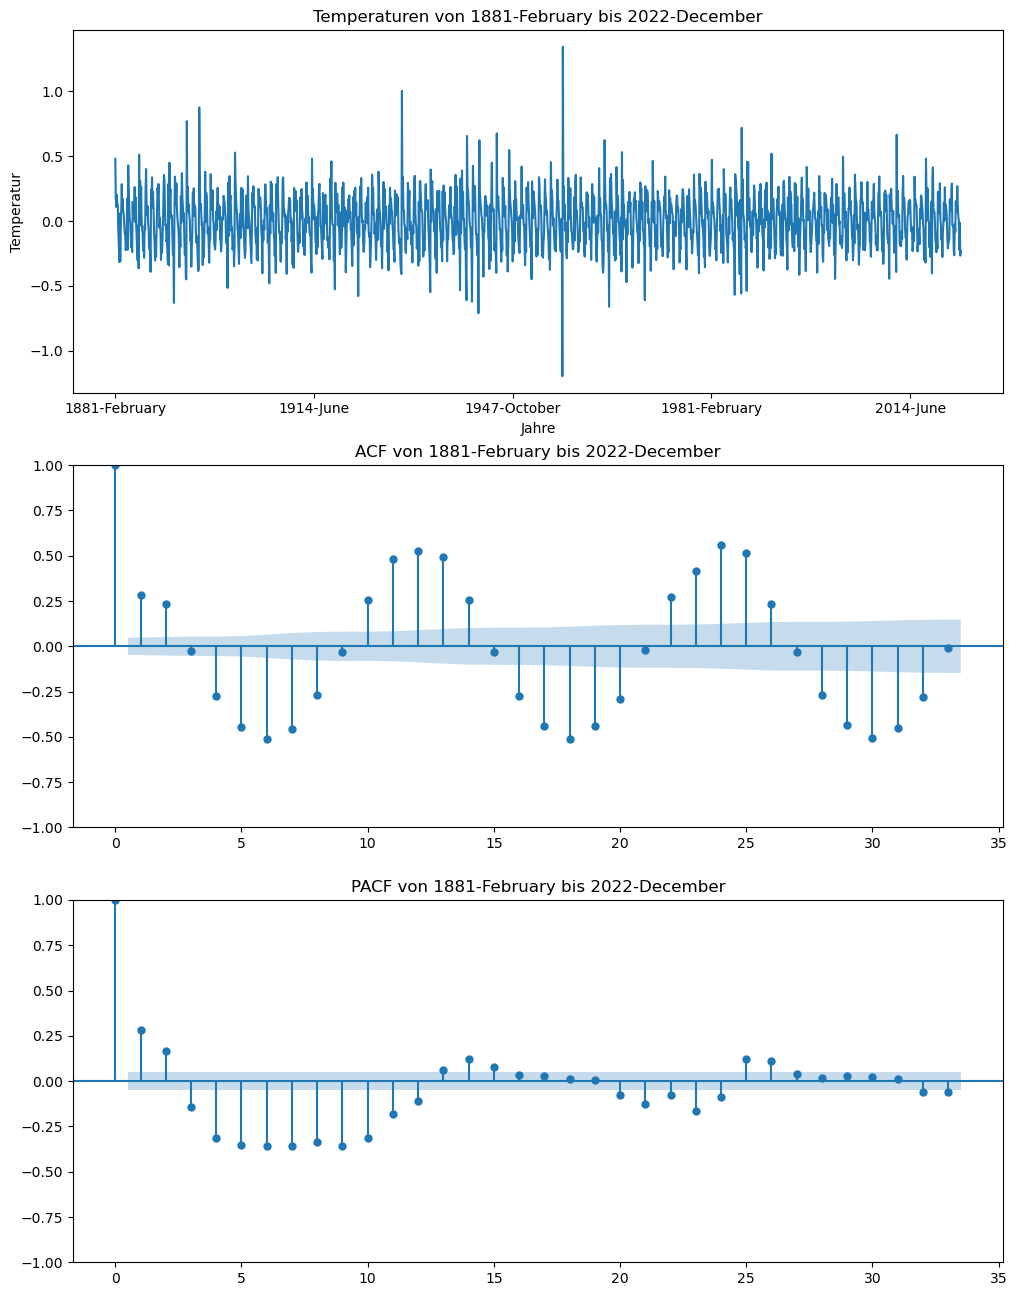

In [10]:
# Berechnung der Differenzwerte für die log-transformierten Werte in "Baden-Wuerttemberg_log"
difference_values = combined_df["Baden-Wuerttemberg_log"].diff(periods=1) # Setzen der Periode hier
Erste_difference_df = pd.DataFrame(index=combined_df.index)
Erste_difference_df["Baden-Wuerttemberg_log_diff"] = difference_values
Erste_difference_df.dropna(inplace=True)
plot_acf_pacf_values(Erste_difference_df, 'Baden-Wuerttemberg_log_diff', '1881-February', '2022-December')


In [11]:
#Für die Erstdifferenzierung
adf_result = adf_test(Erste_difference_df, 'Baden-Wuerttemberg_log_diff', '1881-February', '2022-December')

Test statistic = -14.7368
p-value = 0.0000


#### Periodendifferenz

Jetzt erstellen eine 12-Differenz Dataframes. Die Formel ist: (X(t)- X(t-12)). Dann werden ACF, PACF und der Graph der Dataframes geplottet.

Abbildung 3.5

/Users/Phan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


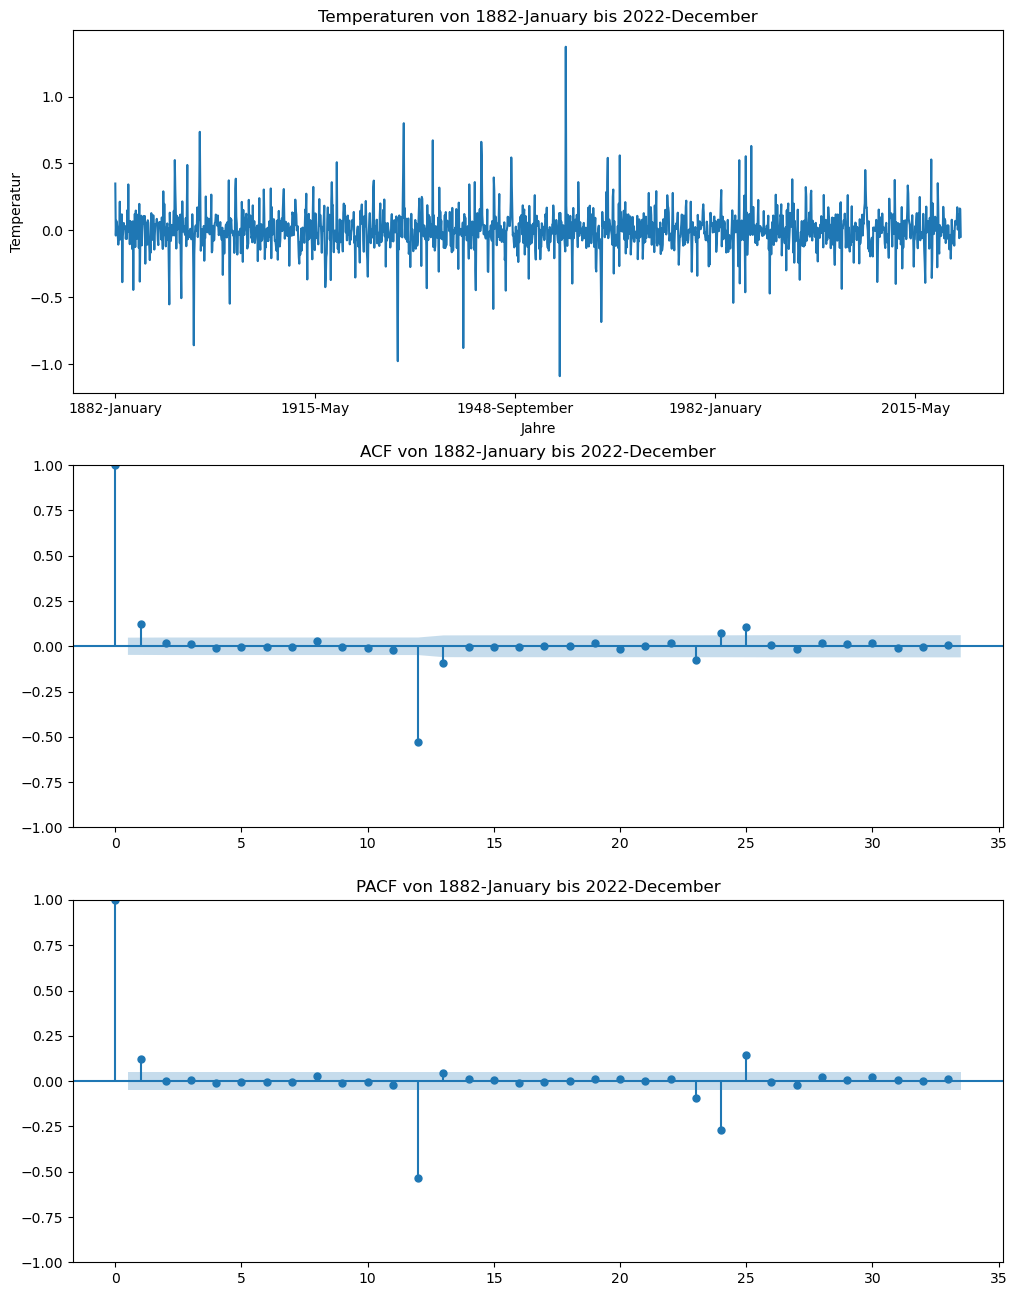

In [12]:
difference_values = combined_df["Baden-Wuerttemberg_log"].diff(periods=12) # set the period here
Period_difference_df = pd.DataFrame(index=combined_df.index)
Period_difference_df["Baden-Wuerttemberg_log_diff"] = difference_values
Period_difference_df.dropna(inplace=True)
#df_to_plot = difference_df_12.iloc[1000:1700]# Choose a range of values to plot
#fig, ax = plt.subplots()

# Plot the difference_df
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
#ax.plot(df_to_plot.index, df_to_plot["Baden-Wuerttemberg_log_diff"])
plot_acf_pacf_values(Period_difference_df, 'Baden-Wuerttemberg_log_diff', '1882-January', '2022-December')

In [13]:
#Für die Periodendifferenz
adf_result = adf_test(Period_difference_df, 'Baden-Wuerttemberg_log_diff', '1882-January', '2022-December')

Test statistic = -11.5748
p-value = 0.0000


#### Erstdifferenz der saisonalen Differenz

Jetzt erstellen eine Erste Differenz der saisonalen Differenz Dataframes. Die Formel ist: (X(t) - X(t-1)) - (X(t-12)- X(t-13)). Dann werden ACF, PACF und der Graph der Dataframes geplottet.

Abbildung 3.6

/Users/Phan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


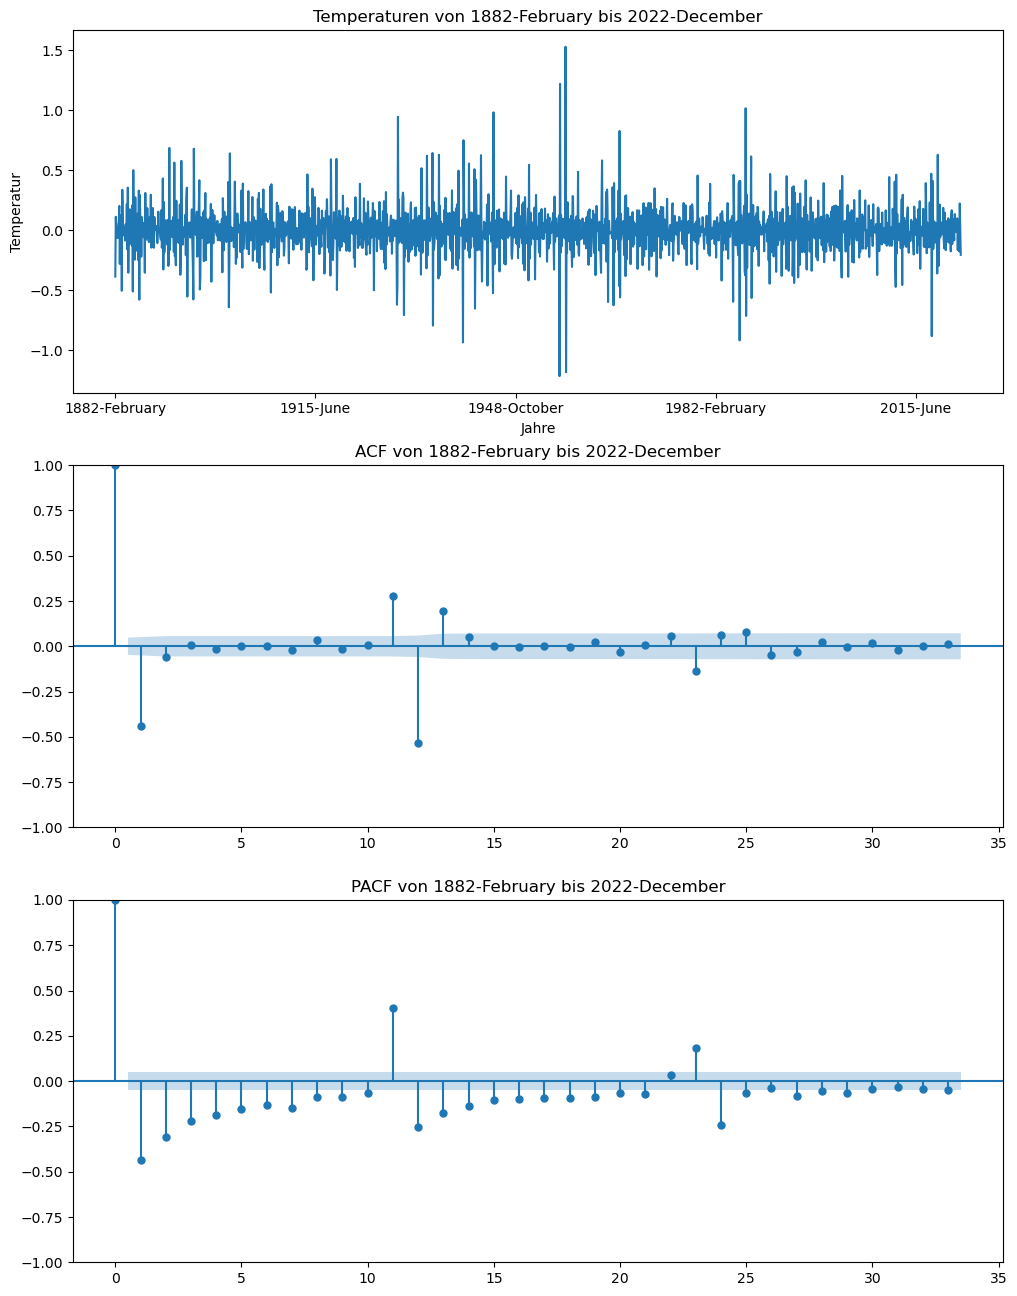

In [14]:
# (Y_t - Y_t-12)
seasonal_difference = combined_df["Baden-Wuerttemberg_log"].diff(12)
seasonal_difference_df = pd.DataFrame(seasonal_difference, columns=["Baden-Wuerttemberg_log"], index=combined_df.index)
# First difference of seasonal difference
first_difference_seasonal_difference = seasonal_difference_df["Baden-Wuerttemberg_log"].diff(1)
first_difference_seasonal_difference_df = pd.DataFrame(first_difference_seasonal_difference, columns=["Baden-Wuerttemberg_log"], index=combined_df.index)
#df_to_plot = first_difference_seasonal_difference_df.iloc[0:1700]
first_difference_seasonal_difference_df.dropna(inplace=True)
#fig, ax = plt.subplots()

# Plot the difference_df
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
#ax.plot(df_to_plot.index, df_to_plot["Baden-Wuerttemberg_log"])
plot_acf_pacf_values(first_difference_seasonal_difference_df, 'Baden-Wuerttemberg_log', '1882-February', '2022-December')

In [15]:
#Für die ErstDifferenz der saisonalen Differenz
adf_result = adf_test(first_difference_seasonal_difference_df, 'Baden-Wuerttemberg_log', '1882-February', '2022-December')


Test statistic = -14.9729
p-value = 0.0000


# 3.4 Modelidentifikation

### 3.4.1 Trainings- und Testdaten

Trainingsdaten, Testdaten erstellen:

In [16]:
import pandas as pd

def split_dataframe(df, column_name):
    num_rows = len(df)
    # Berechnung von 80% der Zeilenanzahl für die Trainingsdaten
    num_rows_80 = int(0.8 * num_rows)
    # Berechnung von 20% der Zeilenanzahl für die Testdaten
    num_rows_20 = int(0.2 * num_rows)

    # Extraktion der Trainingsdaten aus dem DataFrame
    Trainingsdaten = pd.DataFrame(df[column_name].iloc[:num_rows_80])
    # Extraktion der Testdaten aus dem DataFrame
    Testdaten = pd.DataFrame(df[column_name].iloc[num_rows_80:])

    return Trainingsdaten, Testdaten

# Anwendung der split_dataframe-Funktion auf das DataFrame "first_difference_seasonal_difference_df"
Trainingsdaten, Testdaten = split_dataframe(first_difference_seasonal_difference_df, "Baden-Wuerttemberg_log")

# Das DataFrame "first_difference_seasonal_difference_df" enthält die erste Differenz der saisonalen Differenz der 
# ursprünglichen Daten. Der Spaltenname lautet "Baden-Wuerttemberg_log".
# Das DataFrame "Period_difference_df" enthält die saisonale Differenz der ursprünglichen Zeitreihe. Der Spaltenname lautet 
# "Baden-Wuerttemberg_log_diff".


### 3.4.2 Backward-Elimination

Dieses Skript ist Teil der Backward-Elimination. Die Eingabe besteht aus einem DataFrame, den Spaltennamen und dem Modell, dessen Koeffizienten geschätzt werden sollen. Die Ausgabe sind die Werte, die Tabelle 3.1 und 3.2 in der Bachelorarbeit entsprechen.

In [17]:

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import t




def estimate_sarima_params(df, column, order, seasonal_order):
    model = SARIMAX(df[column], order=order, seasonal_order=seasonal_order)
    results = model.fit()

    coef_df = pd.DataFrame({
        'coef': results.params.values,
        'std err': results.bse.values,
        't value': results.tvalues.values,
        'p value': results.pvalues.values
    }, index=results.params.index)

    # Calculate degrees of freedom
    df = len(df[column]) - 8

    # Calculate two-tailed p-value
    coef_df['p value (calc)'] = [2 * (1 - t.cdf(abs(t_val), df)) for t_val in coef_df['t value']]

    # Format p-values
    coef_df['p value'] = coef_df['p value'].map('{:,.5f}'.format)
    coef_df['p value (calc)'] = coef_df['p value (calc)'].map('{:,.5f}'.format)

    return coef_df



coef_df = estimate_sarima_params(Trainingsdaten, 'Baden-Wuerttemberg_log', (1, 0, 0), ([0,1], 0, 1 , 12))
print(coef_df)


/Users/Phan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/Phan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.84652D-01    |proj g|=  2.35051D+00


 This problem is unconstrained.



At iterate    5    f= -5.60541D-01    |proj g|=  5.82994D-01

At iterate   10    f= -5.67698D-01    |proj g|=  5.79944D-01

At iterate   15    f= -5.94641D-01    |proj g|=  1.29713D-01

At iterate   20    f= -6.04277D-01    |proj g|=  1.71965D-01

At iterate   25    f= -6.06056D-01    |proj g|=  5.70266D-02

At iterate   30    f= -6.06330D-01    |proj g|=  2.80047D-02

At iterate   35    f= -6.06358D-01    |proj g|=  5.60032D-03

At iterate   40    f= -6.06362D-01    |proj g|=  8.29404D-04

At iterate   45    f= -6.06362D-01    |proj g|=  3.97562D-05

At iterate   50    f= -6.06362D-01    |proj g|=  8.43374D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/Phan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


              coef   std err    t value  p value p value (calc)
ar.L1    -0.423732  0.013365 -31.704840  0.00000        0.00000
ar.S.L24  0.044235  0.019469   2.272070  0.02308        0.02324
ma.S.L12 -0.999967  5.388537  -0.185573  0.85278        0.85281
sigma2    0.016705  0.089904   0.185810  0.85259        0.85262


### 3.4.3 Brute-Force

Das Skript stammt aus dem Buch von Jochen-Hirsch. Die Grenzen für die Hyperparameter werden angegeben. Die Modellparameter und ihre AIC-Werte werden gespeichert und nach dem niedrigsten AIC an Position 0 des Wörterbuchs sortiert.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from SplitDaten import Trainingsdaten
from BW_WetterImport import combined_df
def brut_force(data):
    cart = [ [i, j] for i in range(2) for j in range(2)]
    orders = [ [ar, 0, ma] for ar in cart for ma in cart]
    seasonal_orders = [ [ar, 1, ma, 12] for ar in cart for ma in cart]
    results = []
    for order in orders:
        for seasonal_order in seasonal_orders:
            try:
                arima = SARIMAX(data, order=order, 
                           seasonal_order=seasonal_order)
                result = arima.fit()
                results.append( {'order':order, 
                             'seasonal_order': seasonal_order, 
                             'log likelihood': result.llf, 
                             'AIC': result.aic } )
            except:
                print('error')
               
    results.sort(key=lambda x : x['AIC'])
    return results

data = combined_df.loc["2007-January":"2019-December", "Baden-Wuerttemberg_log"]
dict = brut_force(data)

Im Folgenden ist das Skript zur Berechnung der AIC-Werte.

In [18]:

import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt



def evaluate_sarima_model(df, column_name, order, seasonal_order):
    # Fit the SARIMA model
    model = SARIMAX(df[column_name], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=0)
    prediction = model_fit.predict()

    # Calculate errors
    #rmse = sqrt(mean_squared_error(df['RMSE'], prediction))
    #mae = mean_absolute_error(df['RMSE'], prediction)

    aic = model_fit.aic

    
    # Print metrics
    #print(f"RMSE: {rmse}")
    #print(f"MAE: {mae}")
    print(f"AIC: {aic}")

    return df

test_test = evaluate_sarima_model(Trainingsdaten, "Baden-Wuerttemberg_log", (0, 0, 1), (0, 0, 1, 12))

/Users/Phan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/Phan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


AIC: -2041.6618978769352


# 3.5 Modeldiagnose

Ein Skript, um die adf und LjungBox-Test durchzuführen:

In [19]:
ffrom statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.compat import lzip
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

# In dieser Funktion werden zwei Spalten hinzugefügt, die die Residuen und die vorhergesagten Werte enthalten,
# in die DataFrame Trainingsdaten.
def add_residuals_and_predicted_column(df, column, order, seasonal_order):
    # Anpassung des SARIMA-Modells
    model = SARIMAX(df[column], order=order, seasonal_order=seasonal_order)
    results = model.fit()

    # Erzeugung von Vorhersagen basierend auf dem Modell
    df['Predicted_Values'] = results.predict(start=0, end=len(df))

    # Berechnung der Residuen
    df['Residuals'] = df[column] - df['Predicted_Values']

    return df

Trainingsdaten = add_residuals_and_predicted_column(Trainingsdaten, 'Baden-Wuerttemberg_log', (2, 0, [0,1]), (2, 0,[0,0,1] , 12))

# Durchführung des Ljungbox-Tests
print(acorr_ljungbox(Trainingsdaten['Residuals'], lags=[24]))


# ADF-Test
def adf_test(df, column, start, end):
    # Auswahl der Daten für den Test
    data = df.loc[start:end, column]
    # Durchführung des ADF-Tests
    result = adfuller(data, regression='n')
    print("Teststatistik = {:.4f}".format(result[0]))
    print("p-Wert = {:.4f}".format(result[1]))
    return result

# Durchführung des ADF-Tests auf die Residuen
adf_result = adf_test(Trainingsdaten, 'Residuals', '1882-February', '1994-September')


/Users/Phan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/Phan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.07822D-01    |proj g|=  2.78108D+00

At iterate    5    f= -7.02007D-01    |proj g|=  3.52285D-01

At iterate   10    f= -7.06041D-01    |proj g|=  4.95706D-01

At iterate   15    f= -7.35318D-01    |proj g|=  7.45760D-01

At iterate   20    f= -7.47484D-01    |proj g|=  4.15999D-02

At iterate   25    f= -7.68720D-01    |proj g|=  3.18523D-02

At iterate   30    f= -7.71537D-01    |proj g|=  1.19569D-01

At iterate   35    f= -7.71683D-01    |proj g|=  4.18887D-03

At iterate   40    f= -7.71688D-01    |proj g|=  2.42710D-02

At iterate   45    f= -7.71871D-01    |proj g|=  5.50635D-02


/Users/Phan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -7.71902D-01    |proj g|=  4.95690D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   4.957D-04  -7.719D-01
  F = -0.77190191651551365     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
      lb_stat  lb_pvalue
24  23.085908   0.514731
Test statistic = -36.9129
p-value = 0.0000


Ein Skript um die Abbildung 3.7, 3.8, 3.9 und 3.10 zu erstellen:

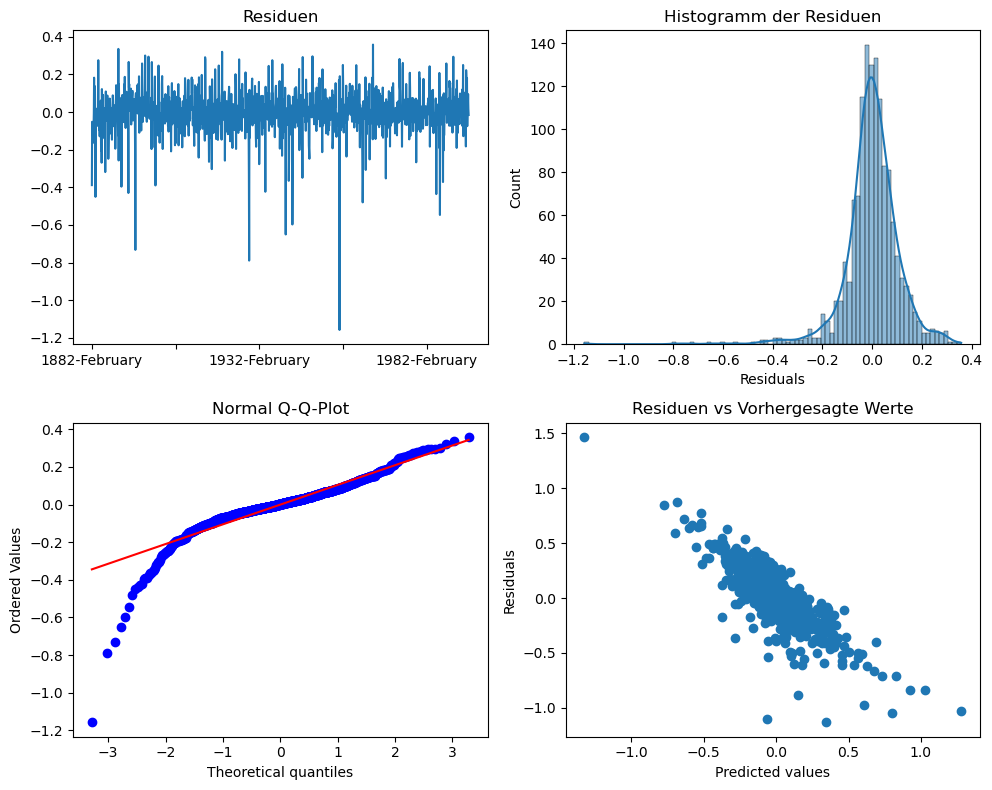

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
def plot_data(df, column, pred_column):
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))

    # Erste Grafik: Residuen
    df[column].plot(ax=ax[0,0])
    ax[0,0].set_title('Residuen')
    ax[0,0].xaxis.set_major_locator(plt.MaxNLocator(5)) # Begrenzung der Anzahl der x-Achsen-Werte auf 5

    # Zweite Grafik: Histogramm
    sns.histplot(df[column], ax=ax[0,1], kde=True)
    ax[0,1].set_title('Histogramm der Residuen')

    # Dritte Grafik: normaler Wahrscheinlichkeitsplot
    stats.probplot(df[column], plot=ax[1,0])
    ax[1,0].set_title('Normal Q-Q-Plot')
    
    # Vierte Grafik: Residuen vs. vorhergesagte Werte
    ax[1,1].scatter(df[pred_column], df[column] - df[pred_column])
    ax[1,1].set_xlabel('Vorhergesagte Werte')
    ax[1,1].set_ylabel('Residuen')
    ax[1,1].set_title('Residuen vs. Vorhergesagte Werte')

    plt.tight_layout()
    plt.show()
    

plot_data(Trainingsdaten, 'Residuals', 'Predicted_Values')


# 3.6 Vorhersage mit dem ausgewählten Modell

## 3.6.1 Vohersage

Abbildung 3.11

/Users/Phan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/Phan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/Phan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


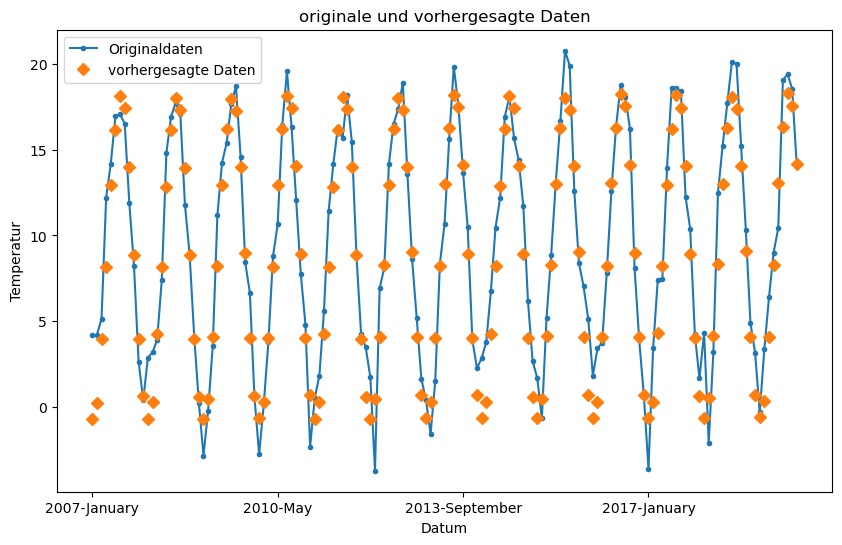

In [22]:
import matplotlib.ticker as ticker

# Funktion zur Prognoseerstellung und Visualisierung der Ergebnisse
def add_predict_and_plot(df, column, order, seasonal_order, start_date, end_date):
    # Anpassung des SARIMA-Modells an die angegebenen Daten.
    model = SARIMAX(df.loc['1881-January':'1994-December', column], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    
    # Hinzufügen der Prognosen zum DataFrame
    df['Predicted'] = model_fit.predict(start=0, end=len(df)-1)

    # Umwandlung der Daten mittels Exponentialfunktion und anschließendes Subtrahieren von 15
    df['Predicted'] = np.exp(df['Predicted']) - 15

    # Plot
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(df.loc[start_date:end_date, 'Baden-Wuerttemberg'], marker = '.', label='Originaldaten')
    ax.plot(df.loc[start_date:end_date, 'Predicted'],'D', label='vorhergesagte Daten',)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))  # limit number of x-axis labels

    plt.title('originale und vorhergesagte Daten')
    plt.xlabel('Datum')
    plt.ylabel('Temperatur')
    plt.legend()
    plt.show()

    return df, model_fit

# start_date und end_date is the intervall to plot.
new_df, model_fit = add_predict_and_plot(combined_df, column='Baden-Wuerttemberg_log',
                              order=(2, 1, [0,1]), seasonal_order=(2, 1, [0,0,1], 12), start_date='2007-January', end_date= "2019-September")

Berechnen RMSE und MAE. Hier wird der Bereich in .iloc[] angegeben, um die beiden Werte zu berechnen.

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print('RMSE:', mean_squared_error(new_df['Baden-Wuerttemberg'].iloc[144:], new_df['Predicted'].iloc[144:]))
print('MAE:', mean_absolute_error(new_df['Baden-Wuerttemberg'].iloc[144:], new_df['Predicted'].iloc[144:]))


RMSE: 3.3425324373229834
MAE: 1.4199247083464022


Vorhersagen. Abbildung 3.12

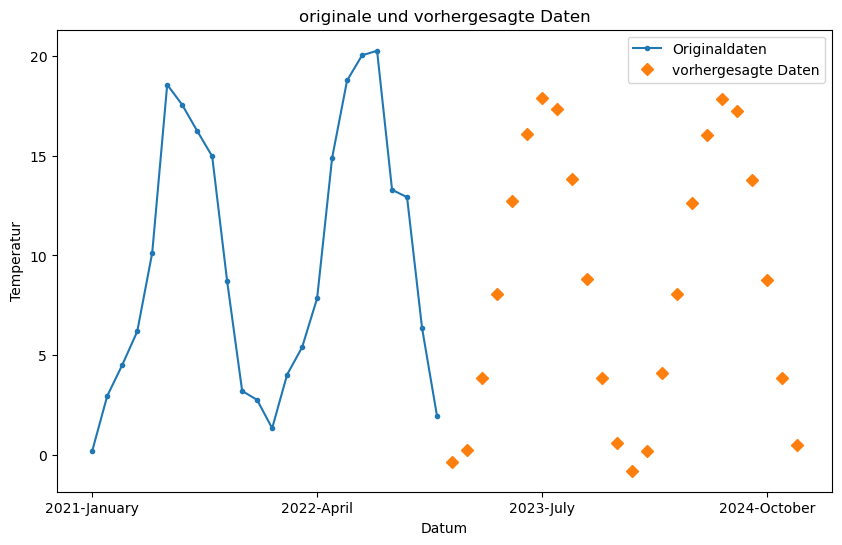

In [24]:

forecast = model_fit.get_forecast(steps=24)
forecast_value = forecast.predicted_mean
forecast_value = np.exp(forecast_value) - 15
forecast_value_df = pd.DataFrame(forecast_value)
date_range = pd.date_range(start='2023-01-01', end='2025-01-01', freq='M')
formatted_date_range = date_range.strftime('%Y-%B')
forecast_value_df.index = formatted_date_range

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(new_df.loc['2021-January':'2022-December', 'Baden-Wuerttemberg'], marker='.', label='Originaldaten')
ax.plot(forecast_value_df.loc['2023-January':'2024-December', 'predicted_mean'], 'D', label='vorhergesagte Daten')
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))

plt.legend()
plt.title('originale und vorhergesagte Daten')
plt.xlabel('Datum')
plt.ylabel('Temperatur')
plt.show()

Trendkomponent der Originalzeitreihe und vorhergesagte Zeitreihe visualisieren. Abbildung 3.13

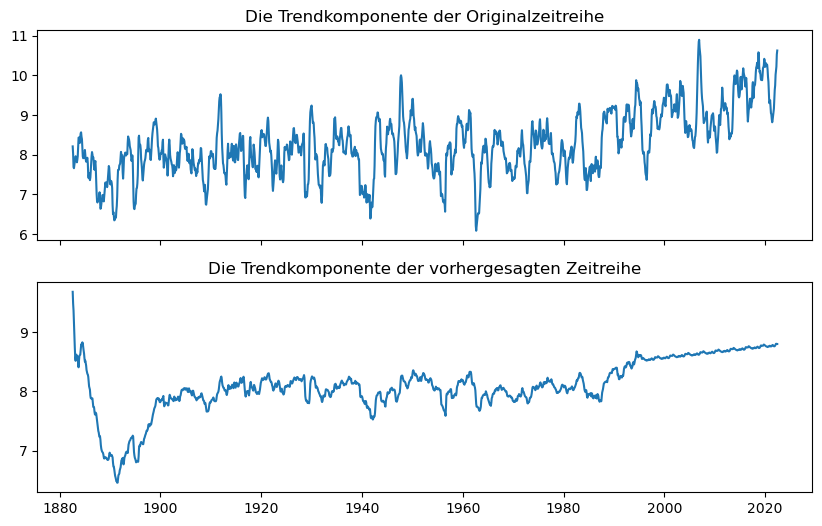

In [24]:
date_rng = pd.date_range(start='1882-02-01', end='2022-12-01', freq='MS')
time_series_1 = pd.Series((new_df.loc['1882-February':'2022-December', 'Baden-Wuerttemberg']).values, index=date_rng)
time_series_2 = pd.Series((new_df.loc['1882-February':'2022-December', 'Predicted']).values, index=date_rng)

result_1 = seasonal_decompose(time_series_1, model='additive', period=12)
result_2 = seasonal_decompose(time_series_2, model='additive', period=12)
trend_1 = result_1.trend
trend_2 = result_2.trend

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,6))
ax1.plot(trend_1)
ax1.set_title('Die Trendkomponente der Originalzeitreihe')
ax2.plot(trend_2)
ax2.set_title('Die Trendkomponente der vorhergesagten Zeitreihe')
plt.show()